# Project - Fifth Requierement

### Import libraries and packages

In [15]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
from itertools import product
from collections import deque
from scipy.optimize import linprog

## Environment

In [16]:
class Environment:
    def __init__(self):
        pass
    def round(self, a_t):
        pass

In [17]:
class PricingEnvironmentMultiProductPiecewiseMean:
    def __init__(self, cost_vector, mean_valuation_schedule, std_valuations, buyers_per_round, total_rounds, num_of_intervals = 3):
        self.cost_vector = np.array(cost_vector)
        self.mean_valuations_list = [np.array(m) for m in mean_valuation_schedule]
        self.std_valuations = np.array(std_valuations)
        self.buyers_per_round = buyers_per_round
        self.total_rounds = total_rounds
        self.current_round = 0
        self.interval_size = total_rounds // num_of_intervals # Compute the round thresholds

    def round(self, p_t_vector):
        # Set right interval
        if self.current_round < self.interval_size:
            mean_valuations = self.mean_valuations_list[0]
        elif self.current_round < 2 * self.interval_size:
            mean_valuations = self.mean_valuations_list[1]
        else:
            mean_valuations = self.mean_valuations_list[2]
        self.current_round += 1

        # Return reward
        prob_buy = 1 - norm.cdf(np.array(p_t_vector), loc=mean_valuations, scale=self.std_valuations)
        num_sales = np.random.binomial(n=self.buyers_per_round, p=prob_buy)
        reward = (np.array(p_t_vector) - self.cost_vector) * num_sales
        return num_sales, reward

### Global settings

In [18]:
# --- Global Settings ---

N = 3                       # Number of products
T = 20000                   # Time horizon
n_trials = 5                # Independent trials

# --- Pricing Grid and Product Info ---

K = 6

costs = np.array([2.0, 2.5, 3.0])                                       # Costs per product

                                   #   P1    P2     P3
mean_valuation_schedule = np.array([[10.0,  5.0,  3.0],    # T1        # Mean valuations for each product at different time intervals
                                    [ 5.0, 10.0,  6.5],    # T2
                                    [ 2.5,  3.0, 10.0]])   # T3

std_valuations = np.array([1.0, 1.2, 0.8])                              # Std for each product

assert len(costs) == len(mean_valuation_schedule) == len(std_valuations) == N, "costs, values, std_valuations must all be of length N"
assert all(costs[i] <= np.min(mean_valuation_schedule, axis=0)[i] for i in range(len(costs))), "Some costs exceed min mean valuation (likely leading to negative margin)"

price_grids = []
for i in range(N):
    p_min = 0.5 * costs[i]
    p_max = max(mean_valuation_schedule[:, i]) * 1.5
    price_grids.append(np.linspace(p_min, p_max, K))

# --- Market and Inventory Parameters ---

B = 120000 * N                                      # Total shared inventory
buyers_per_round = 50                               # Number of buyers per round
rho = B / T

# --- Other Parameters ---

w_size = int(np.round(np.sqrt(T)))                  # Sliding window size for UCB-SW
zoom_end_5 = 5000                                   # Start zooming 5k rounds
s = 30                                              # random seed

# --- Formatter for Millions in the plots---
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

Let's visualize the valuations...

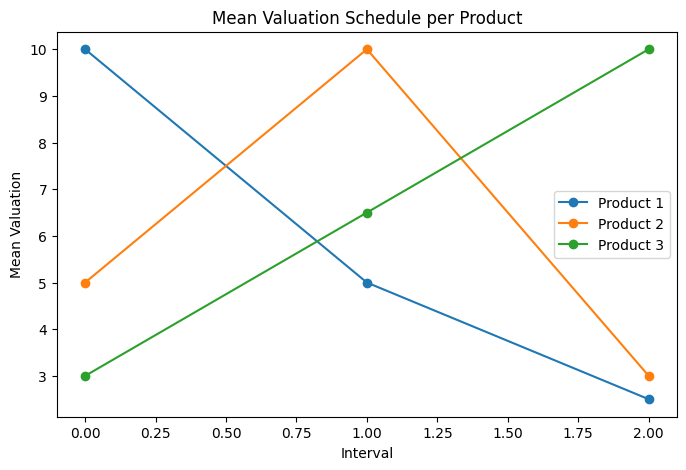

In [19]:
plt.figure(figsize=(8, 5))
for i in range(mean_valuation_schedule.shape[1]):
    plt.plot(range(mean_valuation_schedule.shape[0]), mean_valuation_schedule[:, i], marker='o', label=f'Product {i+1}')
plt.xlabel('Interval')
plt.ylabel('Mean Valuation')
plt.title('Mean Valuation Schedule per Product')
_ = plt.legend()

... and the demand function.

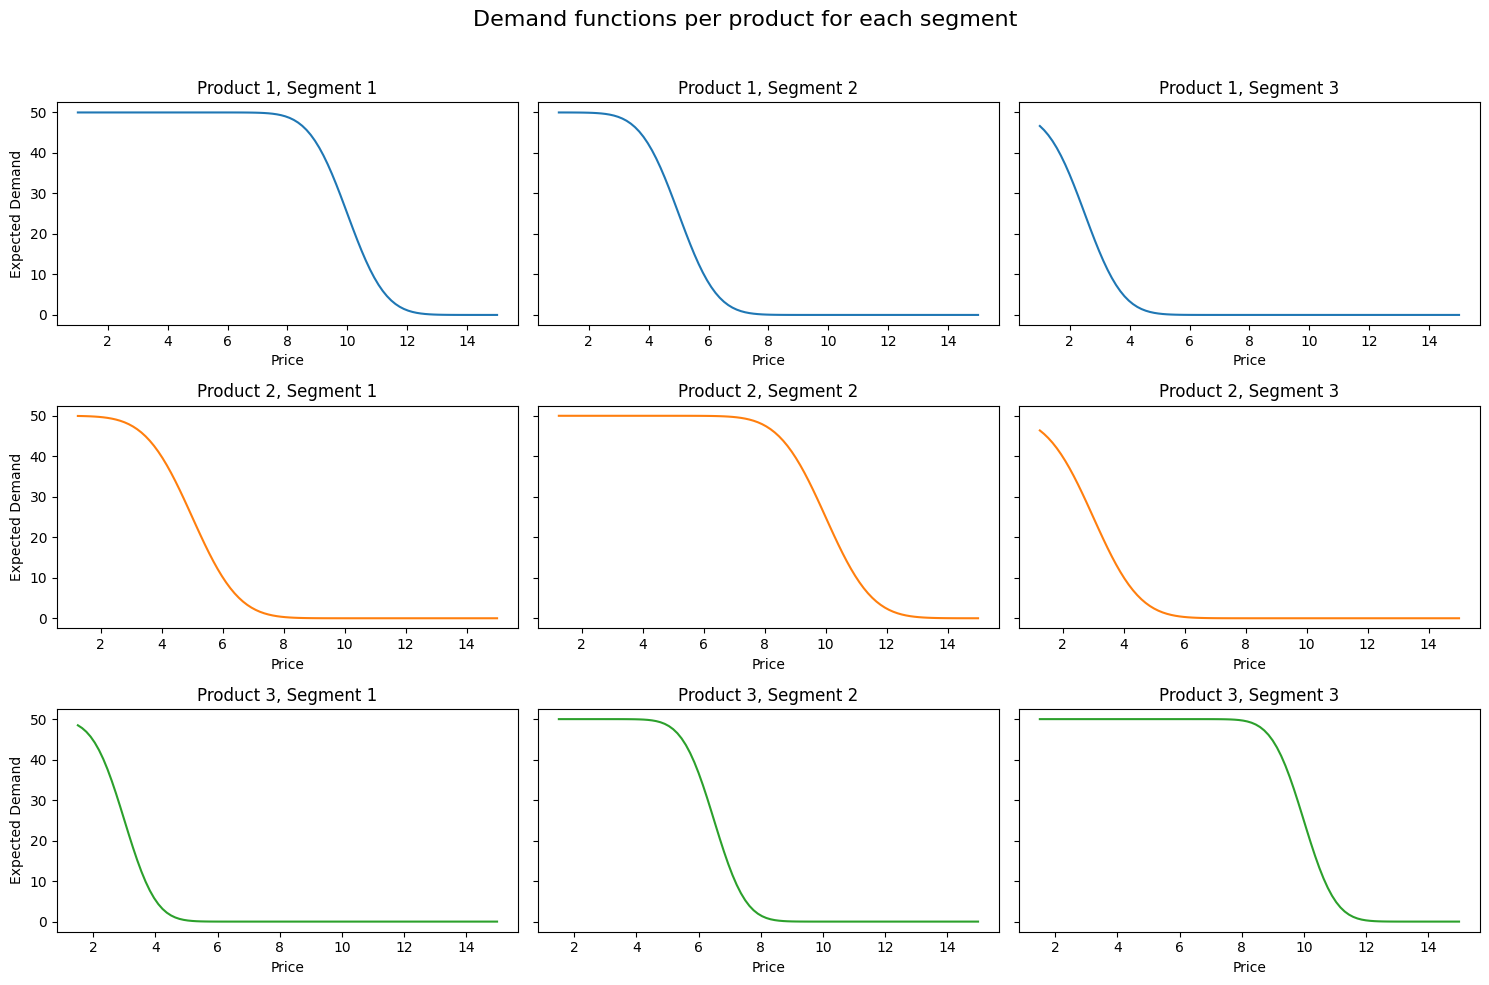

In [20]:
colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, axs = plt.subplots(nrows=N, ncols=len(mean_valuation_schedule), figsize=(15, 10), sharey=True)
fig.suptitle("Demand functions per product for each segment", fontsize=16)

for i in range(N):
    prices = np.linspace(0.5 * costs[i], 1.5 * np.max(mean_valuation_schedule[:, i]), 100)
    for j in range(mean_valuation_schedule.shape[0]):
        mu = mean_valuation_schedule[j, i]
        sigma = std_valuations[i]
        expected_demand = buyers_per_round * (1 - norm.cdf(prices, loc=mu, scale=sigma))
        ax = axs[i, j]
        ax.plot(prices, expected_demand, label=f'Segment {j+1}', color=colors[i])
        ax.set_title(f'Product {i+1}, Segment {j+1}')
        ax.set_xlabel('Price')
        if j == 0:
            ax.set_ylabel('Expected Demand')

plt.tight_layout(rect=[0, 0, 1, 0.96])

### Agents definition

Combinatorial

In [21]:
# If rewards lie in [0, R], you must scale the confidence term by self.range = R maximum possible reward in a round t.
R_ucb = np.array( [ buyers_per_round * (np.max(price_grids[i]) - costs[i]) for i in range(N) ] ) / N / w_size
C_lcb = np.array( [ buyers_per_round for _ in range(N) ] ) / N / w_size

class CombinatorialUCB_SW:
    def __init__(self, price_grids, R_ucb, C_lcb):
        # As before
        self.price_grids = price_grids
        self.R_ucb = R_ucb
        self.C_lcb = C_lcb
        self.rho = rho if T > 0 else 1e-8
        self.t = 0
        self.inventory = B
        self.last_action_idx = None
        self.super_arms = list(product(range(K), repeat=N))
        self.A = len(self.super_arms)
        self.untried_superarms = set(self.super_arms)

        # Sliding window
        self.window_size = w_size
        self.reward_window = [deque(maxlen=self.window_size) for _ in range(self.A)]
        self.sales_window = [deque(maxlen=self.window_size) for _ in range(self.A)]

    def pull_arm(self):
        if self.inventory < 1:
            self.last_action_idx = None
            return None

        # Force exploration: pull each super-arm at least once
        if self.untried_superarms:
            a = self.untried_superarms.pop()
            self.last_action_idx = self.super_arms.index(a)
            return a

        # Compute UCB and LCB using sliding window stats
        ucb_rewards = np.zeros(self.A)
        lcb_sales = np.zeros(self.A)
        for a_idx, (rew_deque, sal_deque) in enumerate(zip(self.reward_window, self.sales_window)): 
            if len(rew_deque) == 0:
                ucb_rewards[a_idx] = float('inf')
                lcb_sales[a_idx] = 0
                continue
            ucb_rewards[a_idx] = np.mean(rew_deque) + sum(self.R_ucb[i] * np.sqrt(2 * np.log(self.t) / len(rew_deque)) for i in range(N))
            lcb_sales[a_idx] = max(0, np.mean(sal_deque) - sum(self.C_lcb[i] * np.sqrt(2 * np.log(self.t) / len(rew_deque)) for i in range(N)))

        # Solve LP
        action_idx = self.solve_lp(ucb_rewards, lcb_sales)
        self.last_action_idx = action_idx
        return self.super_arms[action_idx]

    # As before
    def solve_lp(self, ucb_rewards, lcb_sales):
        c = -ucb_rewards
        A_ub = [lcb_sales]
        b_ub = [self.rho]
        A_eq = [np.ones(self.A)]
        b_eq = [1]
        bounds = [(0, 1)] * self.A

        res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
        if res.success:
            gamma = res.x
            return np.random.choice(self.A, p=gamma)
        else:
            feasible = [i for i, c in enumerate(lcb_sales) if c <= self.rho]
            if feasible:
                return max(feasible, key=lambda i: ucb_rewards[i])
            else:
                return int(np.argmin(lcb_sales))

    # As before
    def update(self, sales, individual_rewards):
        if self.last_action_idx is None:
            return

        total_reward = np.sum(individual_rewards)
        total_sales = np.sum(sales)

        self.reward_window[self.last_action_idx].append(total_reward)
        self.sales_window[self.last_action_idx].append(total_sales)

        self.inventory -= total_sales
        self.t += 1
        self.rho = self.inventory / (T - self.t) if (T - self.t) > 0 else 0

Primal-Dual

In [22]:
# ------------ Primal ------------- #

class EXP3P:
    def __init__(self, K, gamma, eta, max_reward_scale):
        self.K = K
        self.gamma = gamma                          # Exploration rate (how much we don't trust our weights)
        self.eta = eta                              # Learning rate
        self.weights = np.ones(K)
        self.probabilities = np.zeros(K)
        self.max_reward_scale = max_reward_scale    # Safe upper bound on absolute reward

    def choose_action(self):
        # Compute distribution out of weights and choose 
        self.probabilities = (1 - self.gamma) * (self.weights / np.sum(self.weights)) + (self.gamma / self.K)
        self.probabilities /= np.sum(self.probabilities)  # Just in case
        return np.random.choice(self.K, p=self.probabilities)

    def update(self, chosen_action_idx, observed_reward):
        # Compute loss with normalized reward in [0,1]  
        loss_t = (1 - observed_reward / self.max_reward_scale) / 2
        if self.probabilities[chosen_action_idx] != 0:
            estimated_loss = loss_t / self.probabilities[chosen_action_idx]
        else:
            estimated_loss = loss_t
        # Update weights
        self.weights[chosen_action_idx] *= np.exp(-self.eta * estimated_loss)
        # In case weights are getting too large or too small, re-normalize
        if np.sum(self.weights) < 1e-100 or np.sum(self.weights) > 1e100:
            self.weights /= np.max(self.weights)

# ------------- Primal-Dual ------------ #

class PrimalDualCombinatorialPricingAgent:
    def __init__(self, prices, costs, initial_lambda, learning_rate_lambda=0.01, exp3p_gamma=0.001):
        self.prices = prices  # This is now a list of N arrays: prices[i][k]
        self.costs = costs
        self.N = len(prices)
        self.K = len(prices[0])
        self.rho = B / T if T > 0 else 1e-8
        self.lambda_t = initial_lambda
        self.eta_lambda = learning_rate_lambda
        self.superarms = list(product(range(self.K), repeat=self.N))
        self.remaining_budget = B
        self.current_round = 0
        self.max_reward_scale = np.sum([max(self.prices[i]) - self.costs[i] for i in range(self.N)]) * buyers_per_round

        # List of primal regret minimizers for each product
        self.primal_regret_minimizers = [ EXP3P(K=self.K, gamma=exp3p_gamma, eta=np.sqrt(np.log(self.K) / (self.K * T)), max_reward_scale=(max(self.prices[i]) - self.costs[i]) * buyers_per_round ) for i in range(self.N) ]

        # Exploration queue
        self.explored = np.zeros((self.N, self.K), dtype=bool)
        self.exploration_queue = []
        for i in range(self.N):
            for k in range(self.K):
                arm = [np.random.choice(range(self.K)) for _ in range(self.N)]
                arm[i] = k
                self.exploration_queue.append(tuple(arm))
        self.exploration_queue = list(dict.fromkeys(self.exploration_queue))

    def pull_arm(self):
        # Initial exploration (remember: explore all ARMS at least once)
        if not np.all(self.explored):
            superarm = self.exploration_queue.pop(0)
            prices = [self.prices[i][superarm[i]] for i in range(self.N)]
            for i in range(self.N):
                self.explored[i, superarm[i]] = True    
            return prices, superarm

        # Independent EXP3 sampling
        superarm = []
        for i in range(self.N):
            arm = self.primal_regret_minimizers[i].choose_action()
            superarm.append(arm)
        prices = [self.prices[i][superarm[i]] for i in range(self.N)]
        return prices, tuple(superarm)


    def update(self, chosen_arm_indices, sales_vector):
        prices = [self.prices[i][chosen_arm_indices[i]] for i in range(self.N)]
        rewards = [(prices[i] - self.costs[i]) * sales_vector[i] for i in range(self.N)]

        # Update all the regret minimizers
        for i in range(self.N):
            lagrangified_reward = rewards[i] - self.lambda_t * (sales_vector[i] - self.rho/N)
            self.primal_regret_minimizers[i].update(chosen_arm_indices[i], lagrangified_reward)

        # Dual update
        total_consumption = np.sum(sales_vector)
        self.remaining_budget -= total_consumption
        self.current_round += 1
        self.rho = self.remaining_budget / (T - self.current_round) if (T - self.current_round) > 0 else 1e-8

        self.lambda_t += self.eta_lambda * (total_consumption - self.rho)
        self.lambda_t = np.clip(self.lambda_t, 0, self.max_reward_scale)

### Run the experiment

Run simulation.

In [23]:
# --- Dual-agent Simulation ---
all_rewards_dual = {'primal_dual': [], 'ucb_sw': []}
all_sales_dual = {'primal_dual': [], 'ucb_sw': []}

# Run simulation
for seed in range(n_trials):
    np.random.seed(seed)

    # Initialize two environments (identical structure, independent randomness)
    env1 = PricingEnvironmentMultiProductPiecewiseMean(cost_vector=costs, mean_valuation_schedule=mean_valuation_schedule, std_valuations=std_valuations, buyers_per_round=buyers_per_round, total_rounds=T)
    env2 = PricingEnvironmentMultiProductPiecewiseMean(cost_vector=costs, mean_valuation_schedule=mean_valuation_schedule, std_valuations=std_valuations, buyers_per_round=buyers_per_round, total_rounds=T)

    # Agent 1: Primal-Dual
    agent1 = PrimalDualCombinatorialPricingAgent(prices=price_grids, costs=costs, initial_lambda=5*N)
    agent2 = CombinatorialUCB_SW(price_grids=price_grids, R_ucb=R_ucb, C_lcb=C_lcb)

    # For every round
    rewards_1 = []
    rewards_2 = []
    sales1 = []
    sales2 = []
    for t in range(T):

        # Agent 1
        if agent1.remaining_budget >= 1:
            prices1, idxs1 = agent1.pull_arm()
            sales1_vec, reward_vec1 = env1.round(prices1)
            agent1.update(idxs1, sales1_vec)
            rewards_1.append(np.sum(reward_vec1))
            sales1.append(np.sum(sales1_vec))   # <-- track total sales
        else:
            rewards_1.append(0)
            sales1.append(0)

        # Agent 2
        arm2 = agent2.pull_arm()
        if arm2 is not None:
            price_vec2 = [price_grids[i][arm2[i]] for i in range(N)]
            sales2_vec, reward_vec2 = env2.round(price_vec2)
            agent2.update(sales2_vec, reward_vec2)
            rewards_2.append(np.sum(reward_vec2))
            sales2.append(np.sum(sales2_vec))   # <-- track total sales
        else:
            rewards_2.append(0)
            sales2.append(0)

    # Store cumulative info for both
    all_rewards_dual['primal_dual'].append(np.cumsum(rewards_1))
    all_rewards_dual['ucb_sw'].append(np.cumsum(rewards_2))
    all_sales_dual['primal_dual'].append(np.cumsum(sales1))
    all_sales_dual['ucb_sw'].append(np.cumsum(sales2))

Plot comparison

[ Primal - Dual ] Final cumulative reward: 2014245.69
[    UCB - SW   ] Final cumulative reward: 2453310.49


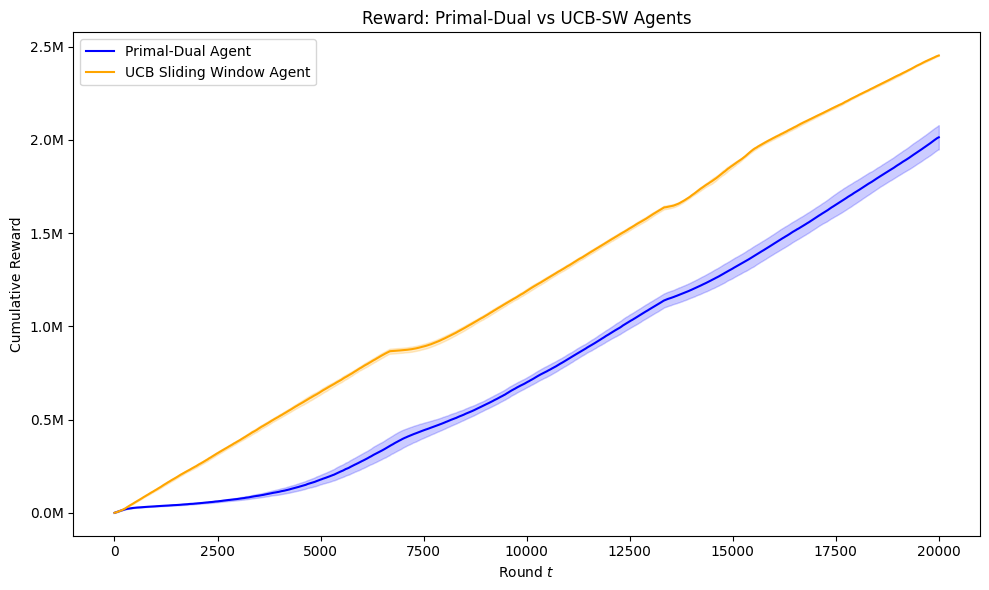

In [24]:
# Convert to numpy arrays
rewards_pd = np.array(all_rewards_dual['primal_dual'])   # shape (n_trials, T)
rewards_ucb = np.array(all_rewards_dual['ucb_sw'])

# Compute mean and std
mean_pd = np.mean(rewards_pd, axis=0)
std_pd = np.std(rewards_pd, axis=0)

mean_ucb = np.mean(rewards_ucb, axis=0)
std_ucb = np.std(rewards_ucb, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(mean_pd, label='Primal-Dual Agent', color='blue')
plt.fill_between(np.arange(T), mean_pd - std_pd, mean_pd + std_pd, color='blue', alpha=0.2)
plt.plot(mean_ucb, label='UCB Sliding Window Agent', color='orange')
plt.fill_between(np.arange(T), mean_ucb - std_ucb, mean_ucb + std_ucb, color='orange', alpha=0.2)
plt.xlabel('Round $t$')
plt.ylabel('Cumulative Reward')
plt.title('Reward: Primal-Dual vs UCB-SW Agents')
plt.legend()
plt.gca().yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))
plt.tight_layout()

# Print final utility
print(f"[ Primal - Dual ] Final cumulative reward: {mean_pd[-1]:.2f}")
print(f"[    UCB - SW   ] Final cumulative reward: {mean_ucb[-1]:.2f}")

Plot inventory consumption.

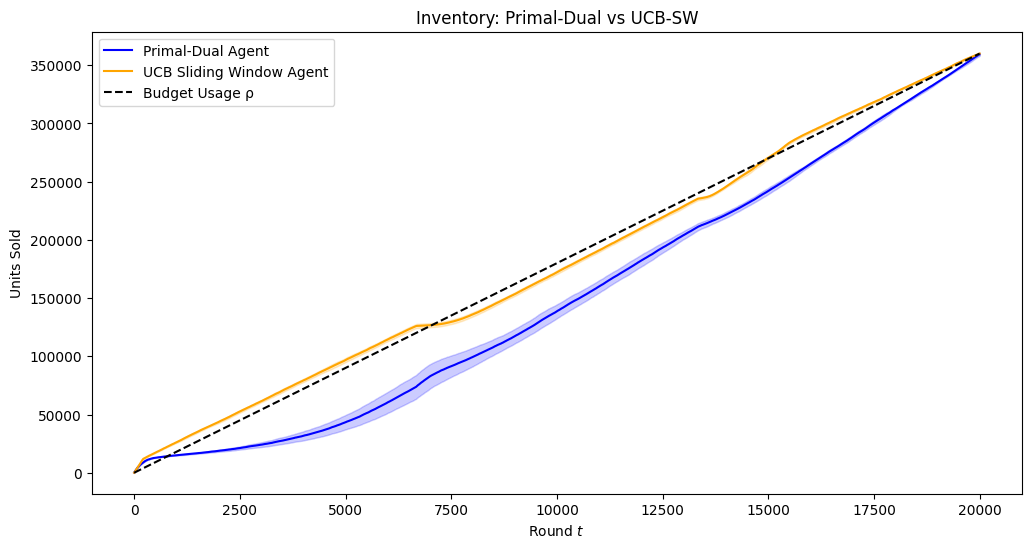

In [25]:
sales_pd = np.array(all_sales_dual['primal_dual'])   # shape (n_trials, T)
sales_ucb = np.array(all_sales_dual['ucb_sw'])

mean_sales_pd = np.mean(sales_pd, axis=0)
std_sales_pd = np.std(sales_pd, axis=0)

mean_sales_ucb = np.mean(sales_ucb, axis=0)
std_sales_ucb = np.std(sales_ucb, axis=0)

plt.figure(figsize=(12, 6))
plt.plot(mean_sales_pd, label='Primal-Dual Agent', color='blue')
plt.fill_between(np.arange(T), mean_sales_pd - std_sales_pd, mean_sales_pd + std_sales_pd, color='blue', alpha=0.2)

plt.plot(mean_sales_ucb, label='UCB Sliding Window Agent', color='orange')
plt.fill_between(np.arange(T), mean_sales_ucb - std_sales_ucb, mean_sales_ucb + std_sales_ucb, color='orange', alpha=0.2)

# Add cumulative function ρ * t
plt.plot(np.arange(T), rho * np.arange(T), label='Budget Usage ρ', color='black', linestyle='--')

plt.xlabel('Round $t$')
plt.ylabel('Units Sold')
plt.title('Inventory: Primal-Dual vs UCB-SW')
_ = plt.legend()

### Regret

Define clairvoyants.

In [26]:
# Helper: Get mean valuation schedule of length T
mean_vals = np.zeros((N, T))
for seg_idx, seg_means in enumerate(mean_valuation_schedule):
    for i in range(N):
        mean_vals[i, seg_idx * env1.interval_size : (seg_idx + 1) * env1.interval_size] = seg_means[i]

# ---------------------------------------
# Clairvoyant 1: Budget-Aware Fixed-Best 
# ---------------------------------------

# For every superarm
best_superarm = None
best_reward = -np.inf
best_budget_spent = None
best_cum_rewards = None
all_superarms = list(product(*[ [p for p in price_grids[i] if p > costs[i]] for i in range(N)]))
for superarm in all_superarms:
    budget_spent = 0.0
    total_reward = 0.0
    cum_rewards = np.zeros(T)
    # For each round
    for t in range(T):
        expected_total_cost = 0.0
        expected_total_reward = 0.0
        # Compute expected cost and reward for this superarm
        for i in range(N):
            price = superarm[i]
            prob_buy = 1 - norm.cdf(price, loc=mean_vals[i, t], scale=std_valuations[i])
            expected_sales = prob_buy * buyers_per_round
            expected_total_cost += expected_sales * price
            expected_total_reward += expected_sales * (price - costs[i])
        if expected_total_cost <= (B - budget_spent):
            budget_spent += expected_total_cost
            total_reward += expected_total_reward
            cum_rewards[t] = cum_rewards[t - 1] + expected_total_reward if t > 0 else expected_total_reward
        else:
            scale = (B - budget_spent) / expected_total_cost if expected_total_cost > 0 else 0.0
            scaled_reward = expected_total_reward * scale
            budget_spent += (B - budget_spent)
            total_reward += scaled_reward
            cum_rewards[t] = cum_rewards[t - 1] + scaled_reward if t > 0 else scaled_reward
            cum_rewards[t + 1 :] = total_reward
            break
    # Check if this superarm is the best one found so far
    if total_reward > best_reward:
        best_reward = total_reward
        best_superarm = superarm
        best_budget_spent = budget_spent
        best_cum_rewards = cum_rewards

clairvoyant1_cum_rewards = best_cum_rewards
print(">>> Budget-Aware Fixed-Best Clairvoyant")
print(f"    Best static superarm: {', '.join(f'{p:.2f}' for p in best_superarm)}")
print(f"    Total expected reward: {clairvoyant1_cum_rewards[-1]:.2f}\n")

# -------------------------------------
# Clairvoyant 2: Overpower Clairvoyant
# -------------------------------------

# Take best price for each product at each round
clairvoyant2_cum_rewards = np.zeros(T)
for t in range(T):
    total_reward_t = 0.0
    for i in range(N):
        best_r = -np.inf
        for p in price_grids[i]:
            prob_buy = 1 - norm.cdf(p, loc=mean_vals[i, t], scale=std_valuations[i])
            exp_sales = prob_buy * buyers_per_round
            expected_reward = exp_sales * (p - costs[i])
            best_r = max(best_r, expected_reward)
        total_reward_t += best_r
    clairvoyant2_cum_rewards[t] = clairvoyant2_cum_rewards[t - 1] + total_reward_t if t > 0 else total_reward_t

print(">>> Overpower No-budget Clairvoyant")
print(f"    Total reward = {clairvoyant2_cum_rewards[-1]:.2f}\n")

# ---------------------------------------------------------------------------------------
# Clairvoyant 3: Generalized Budget-Aware Mixed-Policy Clairvoyant
# ---------------------------------------------------------------------------------------

# Setup
S = mean_valuation_schedule.shape[0]
T_s = env1.interval_size
superarms = list(product(*[ [p for p in price_grids[i] if p > costs[i]] for i in range(N)]))
A = len(superarms)

# Flatten indices: x_{a,s} → index a * S + s
n_vars = A * S
c = np.zeros(n_vars)  # Negative reward (for minimization)

# Build reward and cost matrices averaging the reward across all segments
reward_matrix = np.zeros((A, S))
cost_matrix = np.zeros((A, S))
for a_idx, sa in enumerate(superarms):
    for s in range(S):
        r = 0
        cst = 0
        for i, p in enumerate(sa):
            mu = mean_valuation_schedule[s, i]
            sigma = std_valuations[i]
            prob = 1 - norm.cdf(p, loc=mu, scale=sigma)
            sales = prob * buyers_per_round
            r += sales * (p - costs[i])
            cst += sales * p
        reward_matrix[a_idx, s] = r
        cost_matrix[a_idx, s] = cst
        c[a_idx * S + s] = -T_s * r  # negative for minimization

# Constraints
A_eq = np.zeros((S, n_vars))  # ∑_a x_{a,s} = 1 for each segment
for s in range(S):
    for a_idx in range(A):
        A_eq[s, a_idx * S + s] = 1
b_eq = np.ones(S)

A_ub = np.zeros((1, n_vars))  # Budget constraint
for s in range(S):
    for a_idx in range(A):
        A_ub[0, a_idx * S + s] = T_s * cost_matrix[a_idx, s]
b_ub = [B]

bounds = [(0, 1) for _ in range(n_vars)]

# Solve LP
res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
assert res.success, "LP failed!"

x_opt = res.x.reshape((A, S))  # x_{a,s} per superarm per segment

# Simulate the mixed strategy to get cumulative empirical reward
clairvoyant3_cum_rewards = np.zeros(T)
budget_spent = 0.0
reward_total = 0.0
for t in range(T):
    s = t // T_s  # current segment
    if s >= S:
        s = S - 1
    # Sample a superarm from the distribution for segment s
    probs = x_opt[:, s]
    if probs.sum() == 0:
        continue  # skip if no valid arm
    probs /= probs.sum()
    chosen_idx = np.random.choice(len(superarms), p=probs)
    chosen_sa = superarms[chosen_idx]

    # Compute expected cost and reward this round
    round_reward = 0
    round_cost = 0
    for i, p in enumerate(chosen_sa):
        mu = mean_vals[i, t]
        prob = 1 - norm.cdf(p, loc=mu, scale=std_valuations[i])
        sales = prob * buyers_per_round
        round_reward += sales * (p - costs[i])
        round_cost += sales * p

    if budget_spent + round_cost <= B:
        budget_spent += round_cost
        reward_total += round_reward
    else:
        scale = max(0, (B - budget_spent) / round_cost) if round_cost > 0 else 0
        budget_spent += (B - budget_spent)
        reward_total += round_reward * scale
        clairvoyant3_cum_rewards[t:] = reward_total
        break

    clairvoyant3_cum_rewards[t] = reward_total

print(">>> Mixed-Strategy Clairvoyant (LP-based)")
print(f"    Total reward = {clairvoyant3_cum_rewards[-1]:.2f}")

>>> Budget-Aware Fixed-Best Clairvoyant
    Best static superarm: 9.40, 12.25, 9.60
    Total expected reward: 283404.26

>>> Overpower No-budget Clairvoyant
    Total reward = 6371206.84

>>> Mixed-Strategy Clairvoyant (LP-based)
    Total reward = 286937.46


How do our clairvoyants play?

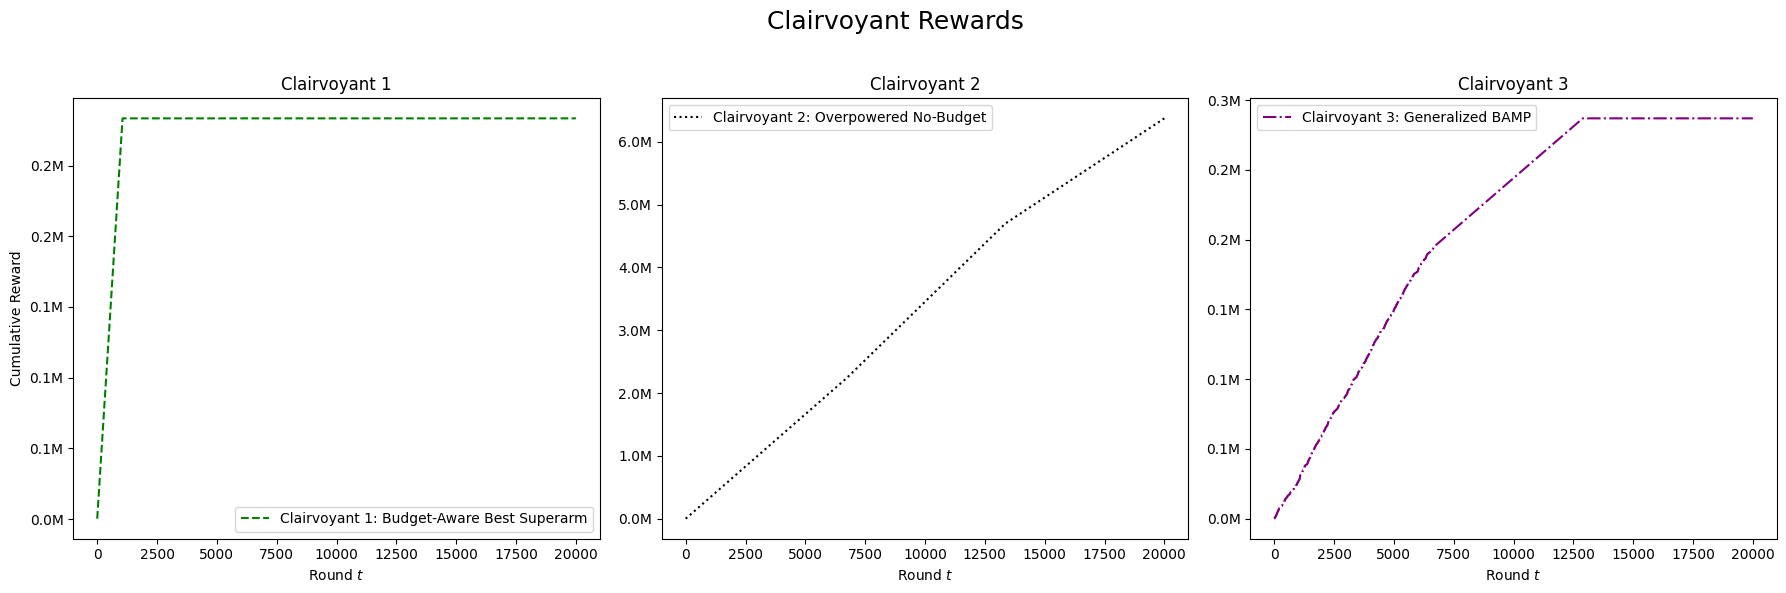

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

# Clairvoyant 1
axs[0].plot(clairvoyant1_cum_rewards, label='Clairvoyant 1: Budget-Aware Best Superarm', color='green', linestyle='--')
axs[0].set_title("Clairvoyant 1")
axs[0].set_xlabel("Round $t$")
axs[0].set_ylabel("Cumulative Reward")
axs[0].legend()
axs[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

# Clairvoyant 2
axs[1].plot(clairvoyant2_cum_rewards, label='Clairvoyant 2: Overpowered No-Budget', color='black', linestyle=':')
axs[1].set_title("Clairvoyant 2")
axs[1].set_xlabel("Round $t$")
axs[1].legend()
axs[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

# Clairvoyant 3
axs[2].plot(clairvoyant3_cum_rewards, label='Clairvoyant 3: Generalized BAMP', color='purple', linestyle='-.')
axs[2].set_title("Clairvoyant 3")
axs[2].set_xlabel("Round $t$")
axs[2].legend()
axs[2].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

fig.suptitle("Clairvoyant Rewards", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])

Now plot regret of both algorithms against each clairvoyant.

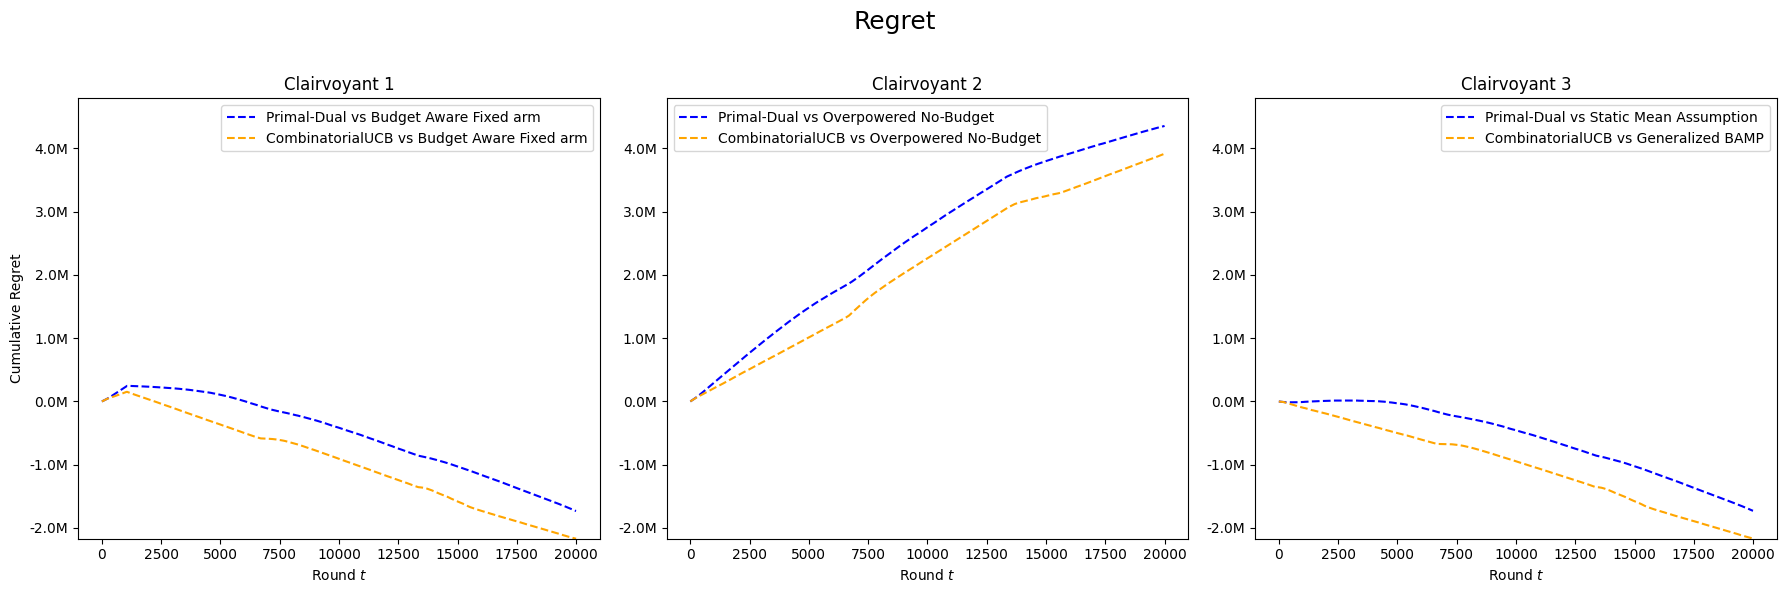

In [28]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharex=True)

regretpd_ba = clairvoyant1_cum_rewards - mean_pd
regretucb_ba = clairvoyant1_cum_rewards - mean_ucb
regretpd_ow = clairvoyant2_cum_rewards - mean_pd
regretucb_ow = clairvoyant2_cum_rewards - mean_ucb
regretpd_sa = clairvoyant3_cum_rewards - mean_pd
regretucb_sa = clairvoyant3_cum_rewards - mean_ucb

# Compute global min/max for y-limitsl min/max for y-limits
all_regrets = np.concatenate([regretpd_ba, regretucb_ba, regretpd_ow, regretucb_ow, regretpd_sa, regretucb_sa])
ymin, ymax = np.min(all_regrets), np.max(all_regrets) * 1.1

# Clairvoyant 1
axs[0].plot(regretpd_ba, label='Primal-Dual vs Budget Aware Fixed arm', color='blue', linestyle='--')
axs[0].plot(regretucb_ba, label='CombinatorialUCB vs Budget Aware Fixed arm', color='orange', linestyle='--')
axs[0].set_title("Clairvoyant 1")
axs[0].set_xlabel("Round $t$")
axs[0].set_ylabel("Cumulative Regret")
axs[0].legend()
axs[0].set_ylim(ymin, ymax)
axs[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

# Clairvoyant 2
axs[1].plot(regretpd_ow, label='Primal-Dual vs Overpowered No-Budget', color='blue', linestyle='--')
axs[1].plot(regretucb_ow, label='CombinatorialUCB vs Overpowered No-Budget', color='orange', linestyle='--')
axs[1].set_title("Clairvoyant 2")
axs[1].set_xlabel("Round $t$")
axs[1].legend()
axs[1].set_ylim(ymin, ymax)
axs[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

# Clairvoyant 3
axs[2].plot(regretpd_sa, label='Primal-Dual vs Static Mean Assumption', color='blue', linestyle='--')
axs[2].plot(regretucb_sa, label='CombinatorialUCB vs Generalized BAMP', color='orange', linestyle='--')
axs[2].set_title("Clairvoyant 3")
axs[2].set_xlabel("Round $t$")
axs[2].legend()
axs[2].set_ylim(ymin, ymax)
axs[2].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions_formatter))

fig.suptitle("Regret", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])